In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename>))

Importing Data

In [7]:
import requests
import io
url = r"https://github.com/IBM-EPBL/IBM-Project-44530-1660725104/blob/main/IBM/Pre-Development/Data%20Collection/Crude%20Oil%20Prices%20Daily.xlsx?raw=true"
download = requests.get(url).content
df = pd.read_excel(url,index_col=0,parse_dates=[0])
print (df.head())


            Closing Value
Date                     
1986-01-02          25.56
1986-01-03          26.00
1986-01-06          26.53
1986-01-07          25.85
1986-01-08          25.87


In [8]:
#Sort dataset by column Date
df = df.sort_values('Date')
df = df.groupby('Date')['Closing Value'].sum().reset_index()
df.set_index('Date', inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [9]:
df.head()

,Closing Value
Date,
2000-01-04,25.56
2000-01-05,24.65
2000-01-06,24.79
2000-01-07,24.79
2000-01-10,24.71


Data Preprocessing

In [10]:
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [11]:
DfInfo(df)

,Closing Value
column type,float64
null values (nb),0
null values (%),0.0


In [12]:
df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-18',
               ...
               '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29',
               '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
               '2018-07-06', '2018-07-09'],
              dtype='datetime64[ns]', name='Date', length=4673, freq=None)

In [13]:
y = df['Closing Value'].resample('MS').mean()

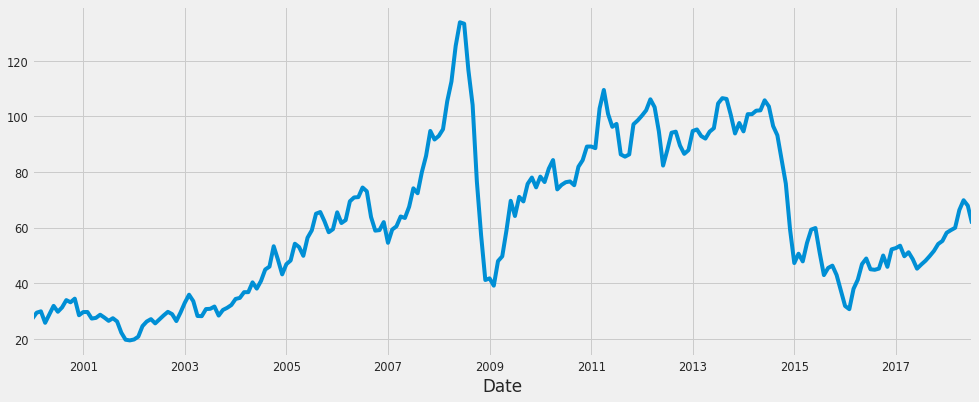

In [14]:
y.plot(figsize=(15, 6))
plt.show()

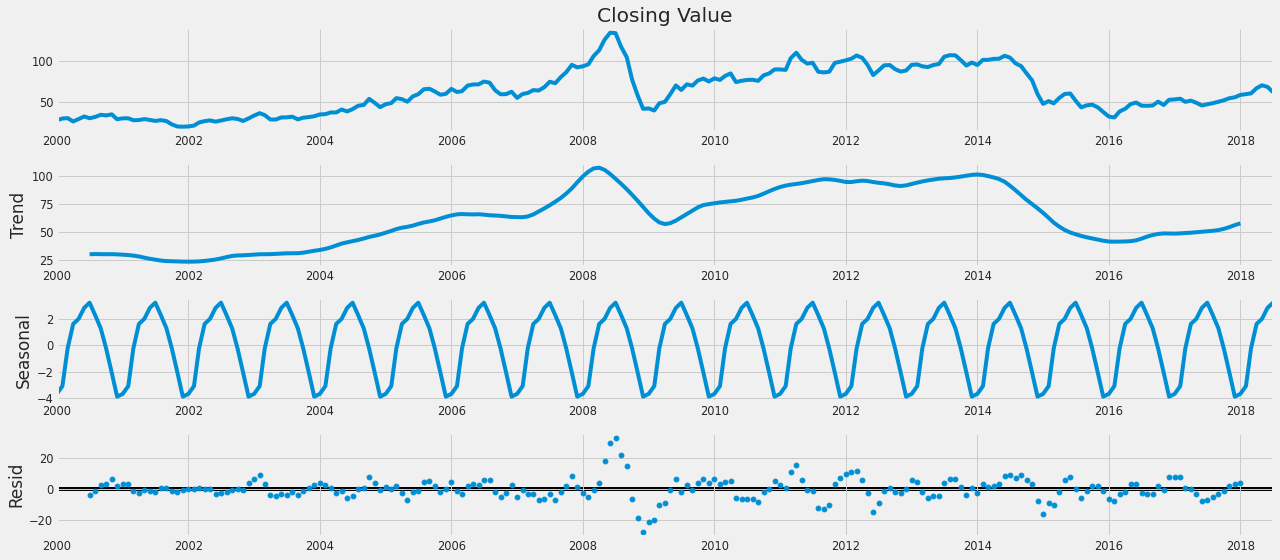

In [15]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [16]:
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

Training and Testing 

In [17]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [18]:
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [19]:
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

LSTM Layer

In [20]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
212/212 [==============================] - 20s 81ms/step - loss: 0.0047 - val_loss: 0.0228 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 13s 63ms/step - loss: 0.0115 - val_loss: 0.0497 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 17s 80ms/step - loss: 0.0155 - val_loss: 0.0547 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 16s 74ms/step - loss: 0.0196 - val_loss: 0.0510 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 16s 77ms/step - loss: 0.0195 - val_loss: 0.0604 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 16s 75ms/step - loss: 0.0169 - val_loss: 0.0462 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 16s 75ms/step - loss: 0.0170 - val_loss: 0.0030 - lr: 1.0000e-04
Epoch 8/20
212/212 [==============================] - 14s 68ms/step - loss: 0.0031 - val_loss: 0.0023 - lr: 1.0000e-04
Epoch 9/20
212/212 [==============================] - 17s 80ms/step - lo

Model Training

In [21]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [22]:
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Prediction

Train Mean Absolute Error: 2.4595469811397526
Train Root Mean Squared Error: 3.3868662837637586
Test Mean Absolute Error: 2.3791246958600936
Test Root Mean Squared Error: 5.264093558111254


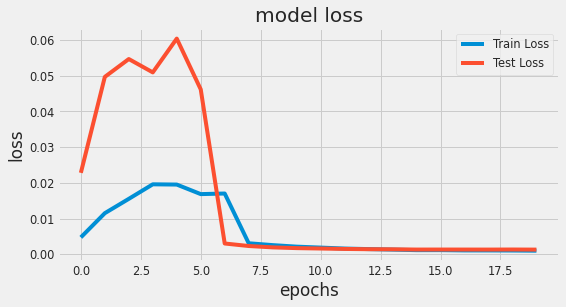

In [23]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

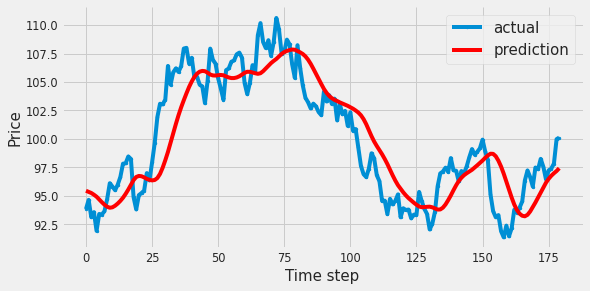

In [24]:
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [25]:
!pip install ibm_watson_machine_learning

In [26]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                    "url": "https://us-south.ml.cloud.ibm.com",
                    "apikey":"9-busktDYuC2Q8WrDBi8OHPVbfHDdwZdMSe7hkojzMfW"
                  }
client = APIClient(wml_credentials)

In [33]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return (next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])
   

In [34]:
space_uid = guid_from_space_name(client, 'Models')
print("Space UID = " + space_uid)

Space UID = f1306808-15bc-44a3-9098-5eecd788c949


In [35]:
client.set.default_space(space_uid)

'SUCCESS'

In [36]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [37]:
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")
software_spec_uid

'e4429883-c883-42b6-87a8-f419d64088cd'